In [497]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import datetime
from datetime import datetime
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input, Dense, Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import optimizers
from keras.constraints import UnitNorm
import missingno as msno
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import evaluate_print
import warnings
warnings.filterwarnings('ignore')

In [292]:
train = pd.read_csv(r'baldwin_pump_data.csv')

In [293]:
train.shape

(12661, 48)

In [294]:
train.head()

,Unnamed: 0,BFP_SEAL_WATER_FLOW,BFP_SUCT_HDR_PRESS________,AUX_CDSR_2B_PRESS_________,BFP_SUCTION_HDR_TEMP______,BFPT_B_VALVE_DEMAND_HP_STO,BFPT_B_VALVE_DEMAND_LP_STO,BFPT_B_CALC_VALVE_DEMAND__,2B_TDBFP_RECIRC_VLV_DMD___,BFP_2B_DISCHARGE_FLOW_____,BFP_2B_IBRD_SEAL_INJ_FLOW_,BFP_2B_OBRD_SEAL_INJ_FLOW_,2B_TDBFP_DISCHARGE_FLOW___,BFP_2B_BAL_DRUM_FLOW______,2B_TDBFP_RECIRC_VLV_POS___,BFP_DSCH_HDR_PRESS________,BFP_2B_LUBE_OIL_PRESS_____,BFPT_2B_FIRST_STAGE_PRESS_,2B_TDBFP_RECIRC_FLOW______,BFPT_B_LP_SPEED_INPUT__1__,BFPT_B_LP_SPEED_INPUT__2__,BFP_DISCHARGE_HEADER_TEMP_,BFP_2B_THRUST_BRG_TEMP____,BFP_2B_IN_BRG_TEMP________,BFP_2B_OUT_BRG_TEMP_______,BFPT_2B_BRG_1_DRAIN_TEMP__,BFPT_2B_BRG_2_DRAIN_TEMP__,BFPT_2B_THRUST_BRG_DRAIN__,BFP_2B_BARREL_TOP_IBRD_TEM,BFP_2B_BARREL_BOT_IBRD_TEM,BFP_2B_BARREL_TOP_OBRD_TEM,BFP_2B_BARREL_BOT_OBRD_TEM,BFPT_2B_IN_BRG_MTL_TEMP___,BFP_2B_IBRD_SEAL_INJ_DRN_T,BFP_2B_OBRD_SEAL_INJ_DRN_T,2B_BFPT_ROTOR_VIB_OBRG____,2B_BFPT_ROTOR_VIB_IBRB____,BFPT_2B_RAD_SHAFT_VIB_OB_B,BFPT_2B_RAD_SHAFT_VIB_IB_B,BFP_2B_AXIAL_SHAFT_VIB____,BFPT_2B_THRUST_BRG_WEAR___,BFP_2B_RAD_SHAFT_VIB_OB_BR,BFP_2B_RAD_SHAFT_VIB_IB_BR,BFPT_2B_AXIAL_SHAFT_VIB___,MAIN_STEAM_FLOW_TO_BFPS___,EXT_STM_FLOW_TO_BFP_2B____,CW_FRM_AUX_CDSR_2B________,CW_TO_AUX_CDS_2B
0,5/1/98 0:00,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,25.44,22.61,-0.02,0.0,100.21,3029.73,NaN,1.65,NaN,0.0,0.0,75.69,NaN,66.42,66.72,63.97,92.19,64.12,66.39,66.1,67.13,66.54,69.08,64.91,64.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
1,5/1/98 0:05,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,25.44,22.61,-0.02,0.0,100.21,3029.73,NaN,1.65,NaN,0.0,0.0,75.69,NaN,66.42,66.72,63.97,92.19,64.11,66.38,66.1,67.13,66.54,69.08,64.91,64.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
2,5/1/98 0:10,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,25.44,22.61,-0.02,0.0,100.21,3029.73,NaN,1.65,NaN,0.0,0.0,75.68,NaN,66.42,66.72,63.97,92.19,64.11,66.38,66.1,67.13,66.54,69.08,64.91,64.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
3,5/1/98 0:15,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,25.44,22.61,-0.02,0.0,100.21,3029.73,NaN,1.65,NaN,0.0,0.0,75.68,NaN,66.42,66.72,63.97,92.19,64.11,66.38,66.1,67.13,66.54,69.08,64.91,64.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
4,5/1/98 0:20,14.34,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,25.44,22.61,-0.02,0.0,100.21,3029.73,NaN,1.65,NaN,0.0,0.0,75.68,NaN,66.42,66.72,63.97,92.19,64.11,66.38,66.1,67.13,66.54,69.08,64.91,64.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72


In [295]:
train.rename(columns = {'Unnamed: 0':'DATETIME'}, inplace = True)

In [296]:
train['DATETIME'] = pd.to_datetime(train['DATETIME'])

In [297]:
train.sort_values(by = 'DATETIME' , inplace = True)

# Check if all Timestamps are present

The data contains timestamps with freq = 5 minutes. But we need to check if all the timestamps are present from the 
start to end timestamp, if not, we need to create the timestamps (rows) and impute the features's values @ the missing
timestamps.

In [298]:
print ('Starting time is: ',train['DATETIME'].min(), 'and Ending time is: ', train['DATETIME'].max())
# Calculate time difference in seconds and convert it into intervals of 5 minutes (300 seconds)
print ((train['DATETIME'].max() - train['DATETIME'].min()).total_seconds()/300)

Starting time is:  1998-05-01 00:00:00 and Ending time is:  1998-06-13 23:00:00
12660.0


Since the time difference equals the number of rows in the train dataframe, there are no missing timestamps. 

In [299]:
train.columns

Index(['DATETIME', 'BFP_SEAL_WATER_FLOW', 'BFP_SUCT_HDR_PRESS________',
       'AUX_CDSR_2B_PRESS_________', 'BFP_SUCTION_HDR_TEMP______',
       'BFPT_B_VALVE_DEMAND_HP_STO', 'BFPT_B_VALVE_DEMAND_LP_STO',
       'BFPT_B_CALC_VALVE_DEMAND__', '2B_TDBFP_RECIRC_VLV_DMD___',
       'BFP_2B_DISCHARGE_FLOW_____', 'BFP_2B_IBRD_SEAL_INJ_FLOW_',
       'BFP_2B_OBRD_SEAL_INJ_FLOW_', '2B_TDBFP_DISCHARGE_FLOW___',
       'BFP_2B_BAL_DRUM_FLOW______', '2B_TDBFP_RECIRC_VLV_POS___',
       'BFP_DSCH_HDR_PRESS________', 'BFP_2B_LUBE_OIL_PRESS_____',
       'BFPT_2B_FIRST_STAGE_PRESS_', '2B_TDBFP_RECIRC_FLOW______',
       'BFPT_B_LP_SPEED_INPUT__1__', 'BFPT_B_LP_SPEED_INPUT__2__',
       'BFP_DISCHARGE_HEADER_TEMP_', 'BFP_2B_THRUST_BRG_TEMP____',
       'BFP_2B_IN_BRG_TEMP________', 'BFP_2B_OUT_BRG_TEMP_______',
       'BFPT_2B_BRG_1_DRAIN_TEMP__', 'BFPT_2B_BRG_2_DRAIN_TEMP__',
       'BFPT_2B_THRUST_BRG_DRAIN__', 'BFP_2B_BARREL_TOP_IBRD_TEM',
       'BFP_2B_BARREL_BOT_IBRD_TEM', 'BFP_2B_BARREL_TOP_O

In [300]:
train.dtypes

DATETIME                      datetime64[ns]
BFP_SEAL_WATER_FLOW                  float64
BFP_SUCT_HDR_PRESS________           float64
AUX_CDSR_2B_PRESS_________           float64
BFP_SUCTION_HDR_TEMP______           float64
BFPT_B_VALVE_DEMAND_HP_STO           float64
BFPT_B_VALVE_DEMAND_LP_STO           float64
BFPT_B_CALC_VALVE_DEMAND__           float64
2B_TDBFP_RECIRC_VLV_DMD___           float64
BFP_2B_DISCHARGE_FLOW_____           float64
BFP_2B_IBRD_SEAL_INJ_FLOW_           float64
BFP_2B_OBRD_SEAL_INJ_FLOW_           float64
2B_TDBFP_DISCHARGE_FLOW___           float64
BFP_2B_BAL_DRUM_FLOW______           float64
2B_TDBFP_RECIRC_VLV_POS___           float64
BFP_DSCH_HDR_PRESS________           float64
BFP_2B_LUBE_OIL_PRESS_____           float64
BFPT_2B_FIRST_STAGE_PRESS_           float64
2B_TDBFP_RECIRC_FLOW______           float64
BFPT_B_LP_SPEED_INPUT__1__           float64
BFPT_B_LP_SPEED_INPUT__2__           float64
BFP_DISCHARGE_HEADER_TEMP_           float64
BFP_2B_THR

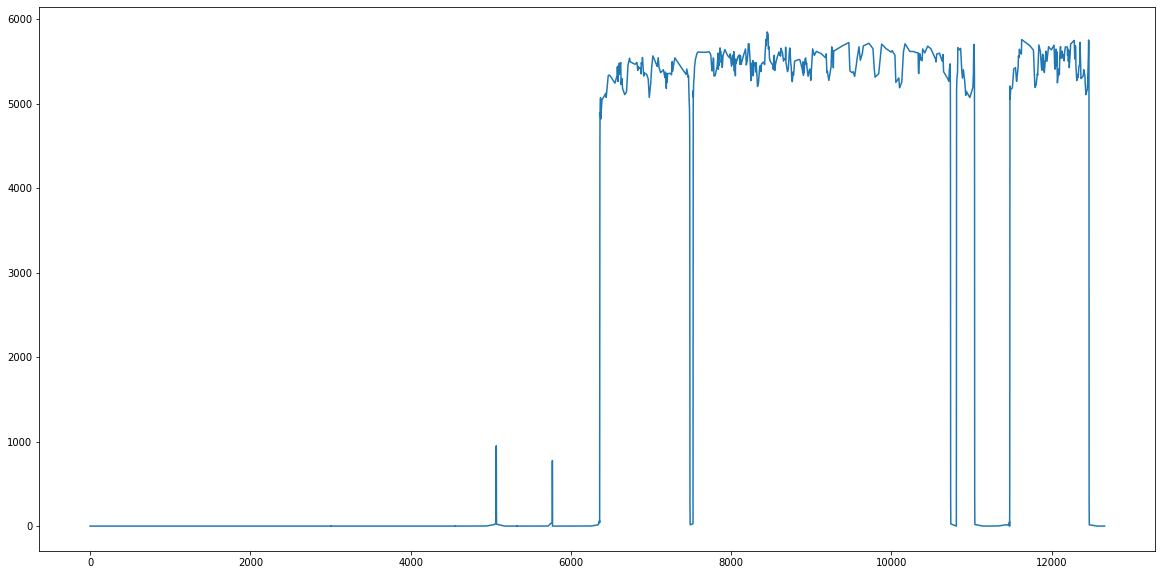

In [301]:
#plt.scatter(train['DATETIME'], train['BFPT_B_LP_SPEED_INPUT__1__'])
plt.plot(train['BFPT_B_LP_SPEED_INPUT__1__'])
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

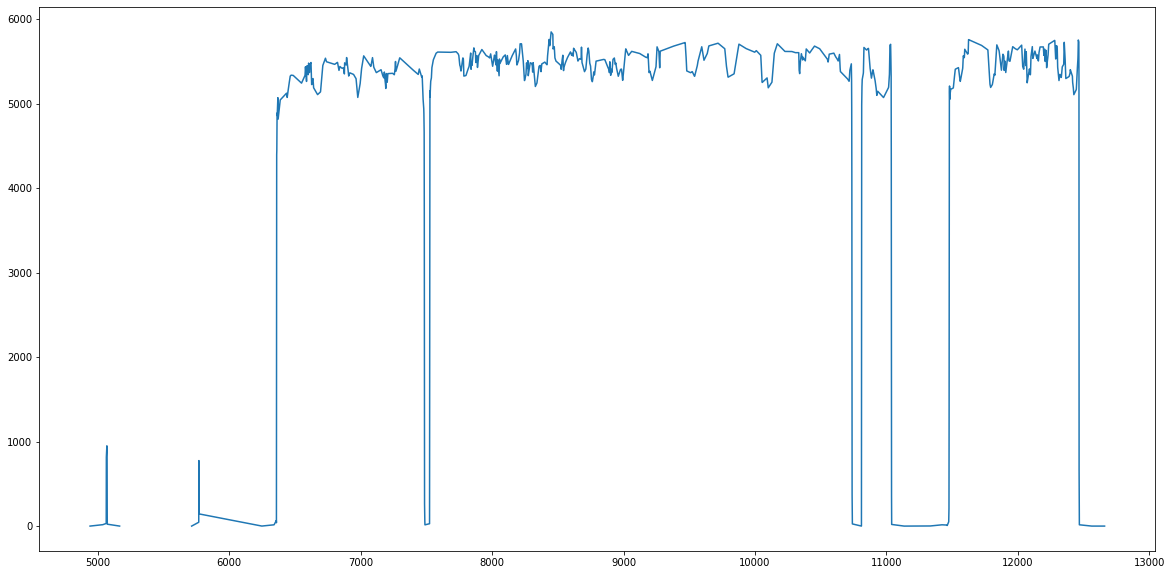

In [302]:
#Plotting when Speed != 0
plt.plot(train.loc[(train['BFPT_B_LP_SPEED_INPUT__1__'] != 0), 'BFPT_B_LP_SPEED_INPUT__1__'])
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

# Plots to understand the Spikes in Speed better

Spike around 5000

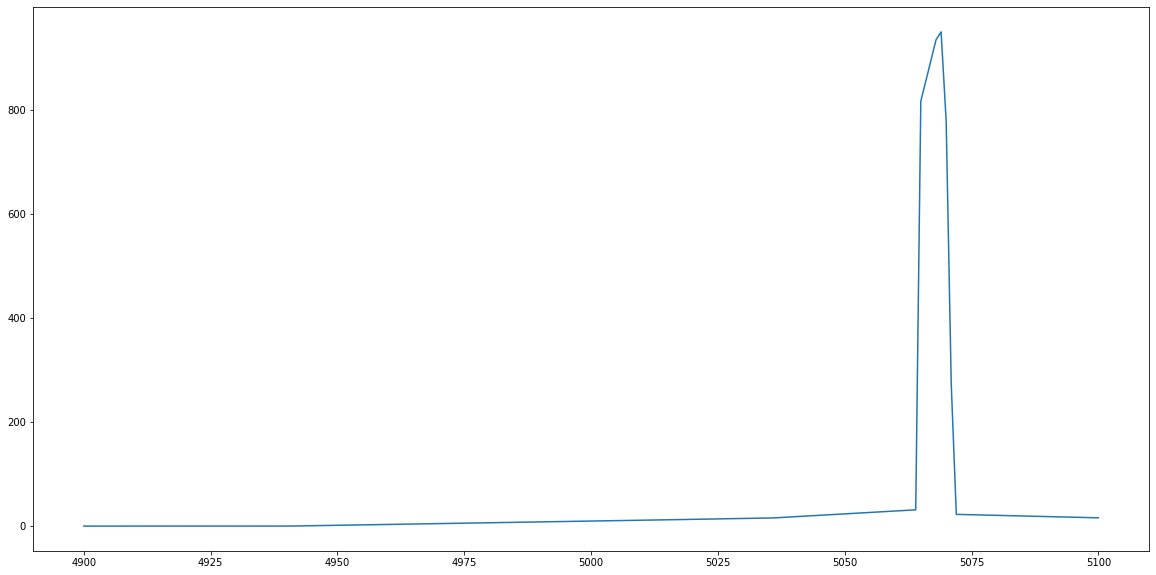

In [303]:
plt.plot(train.ix[4900:5100, 'BFPT_B_LP_SPEED_INPUT__1__'])
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

Spike around 5700

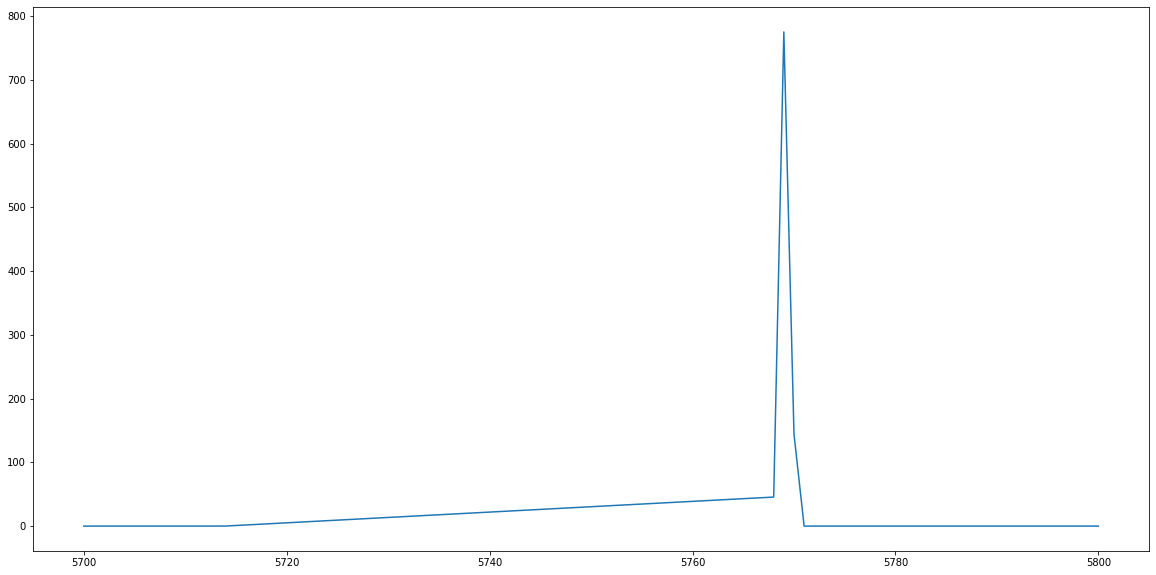

In [304]:
plt.plot(train.ix[5700:5800, 'BFPT_B_LP_SPEED_INPUT__1__'])
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

So the speed suddenly rises to 800 but very briefly for around 10 minutes before it plunges to 0. This does not seem to be normal working operation of the machine.

Spike around 7500

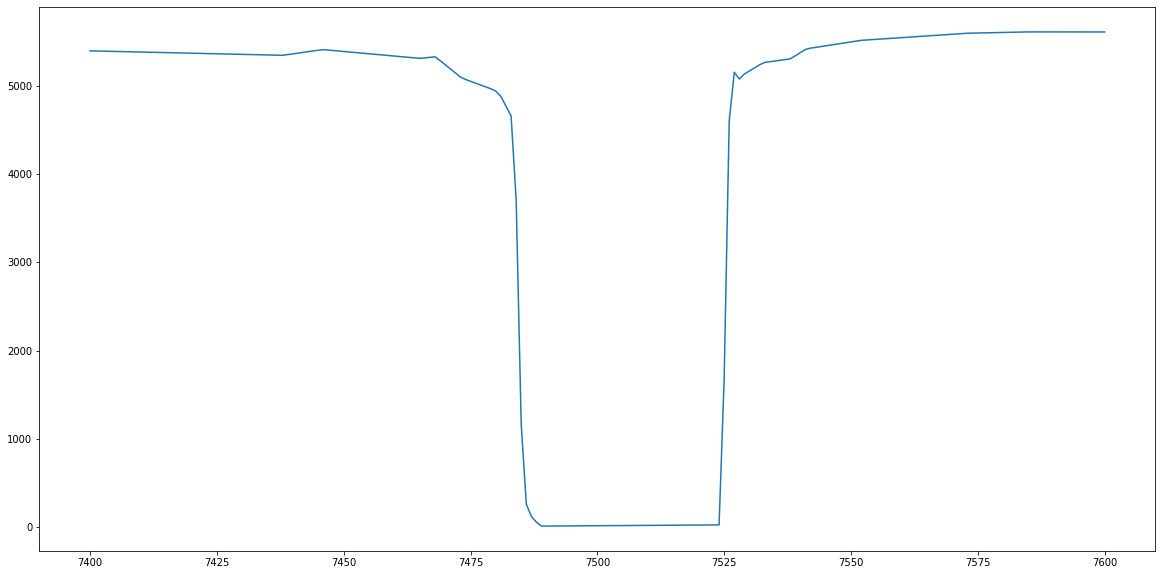

In [305]:
plt.plot(train.ix[7400:7600, 'BFPT_B_LP_SPEED_INPUT__1__'])
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

So the speed is nearly 0 for roughly 200 minutes (40 * 5min) which is not a small period. So the pump was shut down and restarted. 

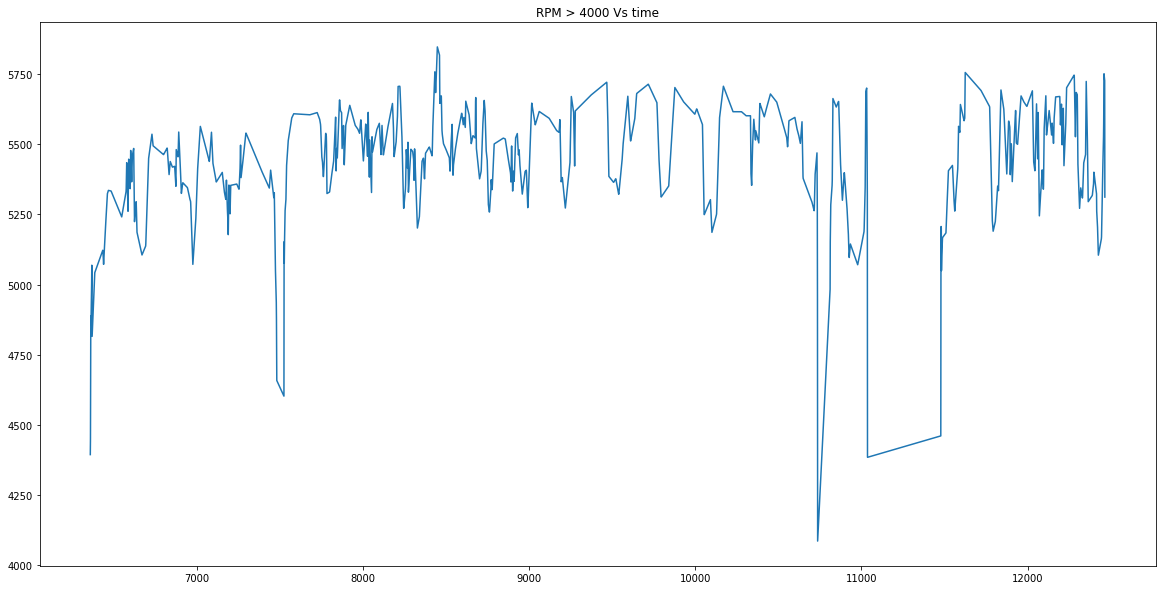

In [306]:
#Plotting when Speed >= 4000
plt.plot(train.loc[(train['BFPT_B_LP_SPEED_INPUT__1__'] >= 4000), 'BFPT_B_LP_SPEED_INPUT__1__'])
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.title('RPM > 4000 Vs time')
plt.show()

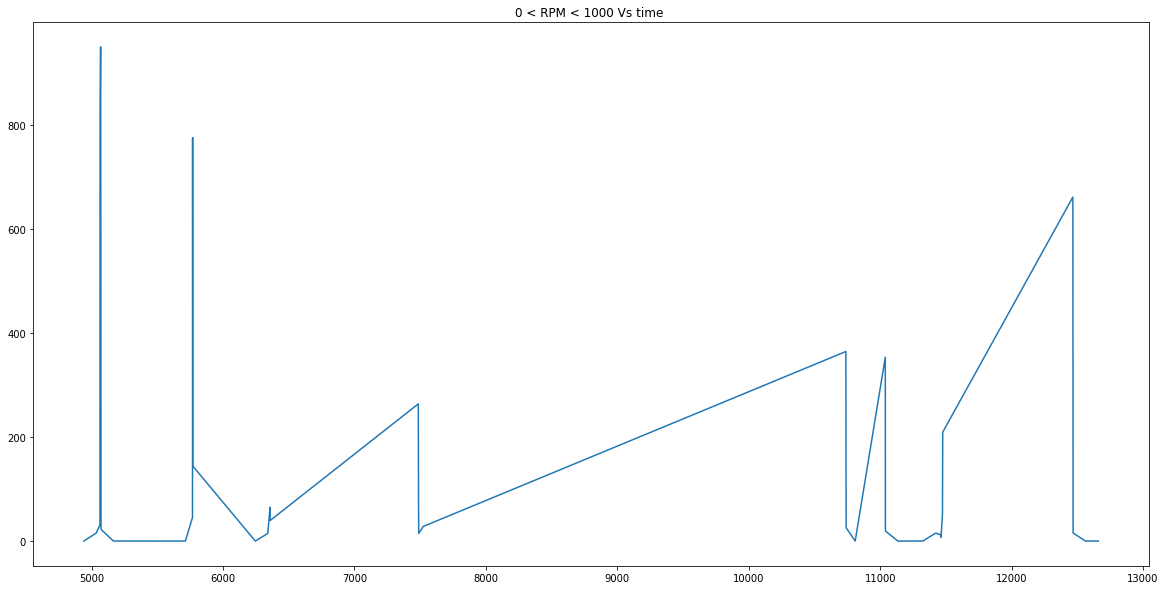

In [307]:
#Plotting when Speed != 0
plt.plot(train.loc[ (train['BFPT_B_LP_SPEED_INPUT__1__'] > 0) & (train['BFPT_B_LP_SPEED_INPUT__1__'] < 1000), 'BFPT_B_LP_SPEED_INPUT__1__'])
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.title('0 < RPM < 1000 Vs time ')
plt.show()

In [308]:
train.loc[(train['BFPT_B_LP_SPEED_INPUT__1__'] != 0), ['DATETIME', 'BFPT_B_LP_SPEED_INPUT__1__']]

,DATETIME,BFPT_B_LP_SPEED_INPUT__1__
3008,1998-05-11 10:40:00,NaN
3009,1998-05-11 10:45:00,NaN
3010,1998-05-11 10:50:00,NaN
4557,1998-05-16 19:45:00,NaN
4558,1998-05-16 19:50:00,NaN
4560,1998-05-16 20:00:00,NaN
4941,1998-05-18 03:45:00,0.08
4942,1998-05-18 03:50:00,0.24
4943,1998-05-18 03:55:00,0.41
4944,1998-05-18 04:00:00,0.57


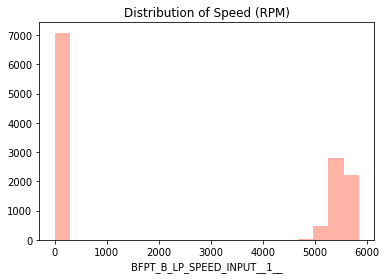

In [309]:
sns.distplot(train["BFPT_B_LP_SPEED_INPUT__1__"], bins = 20, kde = False, color ='#ff4125')
plt.title("Distribution of Speed (RPM)")
plt.show()

# Data Preprocessing - Handling Missing and Negative Values

In [310]:
"""  Function to find missing values  """
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

print(draw_missing_data_table(train).sort_values(by = 'Percent', ascending=False))

                            Total   Percent
BFP_2B_IBRD_SEAL_INJ_FLOW_  11758  0.928679
BFP_2B_OBRD_SEAL_INJ_FLOW_   7531  0.594819
BFPT_2B_AXIAL_SHAFT_VIB___   6862  0.541979
BFPT_2B_RAD_SHAFT_VIB_OB_B   6485  0.512203
2B_BFPT_ROTOR_VIB_OBRG____   6107  0.482347
BFP_2B_AXIAL_SHAFT_VIB____   5727  0.452334
BFP_SUCT_HDR_PRESS________   4114  0.324935
2B_BFPT_ROTOR_VIB_IBRB____   3119  0.246347
BFP_DSCH_HDR_PRESS________   2900  0.229050
BFP_2B_RAD_SHAFT_VIB_OB_BR   2442  0.192876
BFPT_2B_BRG_2_DRAIN_TEMP__   2078  0.164126
BFPT_2B_FIRST_STAGE_PRESS_   1568  0.123845
BFP_2B_LUBE_OIL_PRESS_____   1129  0.089171
BFP_2B_THRUST_BRG_TEMP____    617  0.048732
BFP_2B_OUT_BRG_TEMP_______    543  0.042888
BFP_2B_RAD_SHAFT_VIB_IB_BR    180  0.014217
BFPT_2B_RAD_SHAFT_VIB_IB_B    108  0.008530
2B_TDBFP_RECIRC_FLOW______     96  0.007582
EXT_STM_FLOW_TO_BFP_2B____     89  0.007029
BFPT_2B_THRUST_BRG_WEAR___     86  0.006793
CW_FRM_AUX_CDSR_2B________     26  0.002054
MAIN_STEAM_FLOW_TO_BFPS___     1

In [311]:
# Check when Speed is NaN
train[train['BFPT_B_LP_SPEED_INPUT__1__'].isna()]

,DATETIME,BFP_SEAL_WATER_FLOW,BFP_SUCT_HDR_PRESS________,AUX_CDSR_2B_PRESS_________,BFP_SUCTION_HDR_TEMP______,BFPT_B_VALVE_DEMAND_HP_STO,BFPT_B_VALVE_DEMAND_LP_STO,BFPT_B_CALC_VALVE_DEMAND__,2B_TDBFP_RECIRC_VLV_DMD___,BFP_2B_DISCHARGE_FLOW_____,BFP_2B_IBRD_SEAL_INJ_FLOW_,BFP_2B_OBRD_SEAL_INJ_FLOW_,2B_TDBFP_DISCHARGE_FLOW___,BFP_2B_BAL_DRUM_FLOW______,2B_TDBFP_RECIRC_VLV_POS___,BFP_DSCH_HDR_PRESS________,BFP_2B_LUBE_OIL_PRESS_____,BFPT_2B_FIRST_STAGE_PRESS_,2B_TDBFP_RECIRC_FLOW______,BFPT_B_LP_SPEED_INPUT__1__,BFPT_B_LP_SPEED_INPUT__2__,BFP_DISCHARGE_HEADER_TEMP_,BFP_2B_THRUST_BRG_TEMP____,BFP_2B_IN_BRG_TEMP________,BFP_2B_OUT_BRG_TEMP_______,BFPT_2B_BRG_1_DRAIN_TEMP__,BFPT_2B_BRG_2_DRAIN_TEMP__,BFPT_2B_THRUST_BRG_DRAIN__,BFP_2B_BARREL_TOP_IBRD_TEM,BFP_2B_BARREL_BOT_IBRD_TEM,BFP_2B_BARREL_TOP_OBRD_TEM,BFP_2B_BARREL_BOT_OBRD_TEM,BFPT_2B_IN_BRG_MTL_TEMP___,BFP_2B_IBRD_SEAL_INJ_DRN_T,BFP_2B_OBRD_SEAL_INJ_DRN_T,2B_BFPT_ROTOR_VIB_OBRG____,2B_BFPT_ROTOR_VIB_IBRB____,BFPT_2B_RAD_SHAFT_VIB_OB_B,BFPT_2B_RAD_SHAFT_VIB_IB_B,BFP_2B_AXIAL_SHAFT_VIB____,BFPT_2B_THRUST_BRG_WEAR___,BFP_2B_RAD_SHAFT_VIB_OB_BR,BFP_2B_RAD_SHAFT_VIB_IB_BR,BFPT_2B_AXIAL_SHAFT_VIB___,MAIN_STEAM_FLOW_TO_BFPS___,EXT_STM_FLOW_TO_BFP_2B____,CW_FRM_AUX_CDSR_2B________,CW_TO_AUX_CDS_2B
3008,1998-05-11 10:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3009,1998-05-11 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3010,1998-05-11 10:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4557,1998-05-16 19:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4558,1998-05-16 19:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4560,1998-05-16 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5320,1998-05-19 11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5322,1998-05-19 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5323,1998-05-19 11:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5325,1998-05-19 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So every variable is NaN when Speed is NaN. So we can delete these rows. 

In [312]:
train.iloc[3008, ]

DATETIME                      1998-05-11 10:40:00
BFP_SEAL_WATER_FLOW                           NaN
BFP_SUCT_HDR_PRESS________                    NaN
AUX_CDSR_2B_PRESS_________                    NaN
BFP_SUCTION_HDR_TEMP______                    NaN
BFPT_B_VALVE_DEMAND_HP_STO                    NaN
BFPT_B_VALVE_DEMAND_LP_STO                    NaN
BFPT_B_CALC_VALVE_DEMAND__                    NaN
2B_TDBFP_RECIRC_VLV_DMD___                    NaN
BFP_2B_DISCHARGE_FLOW_____                    NaN
BFP_2B_IBRD_SEAL_INJ_FLOW_                    NaN
BFP_2B_OBRD_SEAL_INJ_FLOW_                    NaN
2B_TDBFP_DISCHARGE_FLOW___                    NaN
BFP_2B_BAL_DRUM_FLOW______                    NaN
2B_TDBFP_RECIRC_VLV_POS___                    NaN
BFP_DSCH_HDR_PRESS________                    NaN
BFP_2B_LUBE_OIL_PRESS_____                    NaN
BFPT_2B_FIRST_STAGE_PRESS_                    NaN
2B_TDBFP_RECIRC_FLOW______                    NaN
BFPT_B_LP_SPEED_INPUT__1__                    NaN


In [313]:
train.shape

(12661, 48)

In [315]:
train = train[train['BFPT_B_LP_SPEED_INPUT__1__'].notnull()]

Many of the missing values in variables like Seal Flow, Vibration, Lube Oil Pressure etc. maybe missing when the Pump is not
running (Speed = 0).

In [316]:
# Check for Missing values when Pump is Running
print(draw_missing_data_table(train[train['BFPT_B_LP_SPEED_INPUT__1__'] != 0]).sort_values(by = 'Percent', ascending=False))

                            Total   Percent
BFP_2B_IBRD_SEAL_INJ_FLOW_   6035  0.941204
BFP_2B_OBRD_SEAL_INJ_FLOW_   1776  0.276981
BFPT_2B_AXIAL_SHAFT_VIB___    633  0.098721
BFP_SUCT_HDR_PRESS________    487  0.075951
BFPT_2B_FIRST_STAGE_PRESS_    482  0.075172
BFPT_2B_RAD_SHAFT_VIB_OB_B    337  0.052558
BFP_2B_AXIAL_SHAFT_VIB____    241  0.037586
2B_BFPT_ROTOR_VIB_OBRG____    240  0.037430
2B_BFPT_ROTOR_VIB_IBRB____    206  0.032127
BFP_2B_LUBE_OIL_PRESS_____    131  0.020430
BFP_2B_OUT_BRG_TEMP_______     35  0.005459
BFP_2B_THRUST_BRG_TEMP____     35  0.005459
BFP_2B_RAD_SHAFT_VIB_OB_BR     32  0.004991
BFPT_2B_RAD_SHAFT_VIB_IB_B      5  0.000780
CW_FRM_AUX_CDSR_2B________      1  0.000156
BFP_2B_BARREL_BOT_OBRD_TEM      0  0.000000
MAIN_STEAM_FLOW_TO_BFPS___      0  0.000000
BFP_2B_RAD_SHAFT_VIB_IB_BR      0  0.000000
BFPT_2B_THRUST_BRG_WEAR___      0  0.000000
BFP_2B_OBRD_SEAL_INJ_DRN_T      0  0.000000
BFP_2B_IBRD_SEAL_INJ_DRN_T      0  0.000000
BFPT_2B_IN_BRG_MTL_TEMP___      

As expected, the number of missing values when Speed is not 0 is much lower (except for BFP_2B_IBRD_SEAL_INJ_FLOW_ and BFP_2B_OBRD_SEAL_INJ_FLOW_). These can be imputed. But we will detect and filter Pump Running State first before Imputing.  

# Detecting Change Points in Speed

We check for values that lie below 4500 (to ignore NaNs and to ignore variation in the running/operating range of 4000-6000 RPM)

In [317]:
temp = train.loc[ (train['BFPT_B_LP_SPEED_INPUT__1__'].notna()) & (train['BFPT_B_LP_SPEED_INPUT__1__'] < 4500), 'BFPT_B_LP_SPEED_INPUT__1__']
temp = temp.index[np.abs(temp.diff()) > 300]
print(temp)

Int64Index([ 5065,  5071,  5769,  5770,  6360,  6361,  7484,  7485,  7486,
             7525, 10737, 10738, 10739, 10811, 11037, 11038, 11039, 11040,
            11477, 11478, 12466, 12467],
           dtype='int64')


As observed above, there are sudden spikes in Speed at Indices 5065, 5769, 6360, 6361, 7525, 10737, 10811, 11037 and 11477- 11478. We can inspect these further.

5062     30.12
5063     30.68
5064     31.23
5065    816.18
5066    855.52
5067    894.85
5068    934.18
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
5068    934.18
5069    949.52
5070    778.31
5071    273.19
5072     22.53
5073     22.30
5074     22.06
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
5766     43.85
5767     44.69
5768     45.53
5769    775.22
5770    144.34
5771      0.00
5772      0.00
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
5767     44.69
5768     45.53
5769    775.22
5770    144.34
5771      0.00
5772      0.00
5773      0.00
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
6357      61.93
6358      64.84
6359      39.62
6360    2158.47
6361    4393.84
6362    4449.90
6363    4681.88
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
6358      64.84
6359      39.62
6360    2158.47
6361    4393.84
6362    4449.90
6363    4681.88
6364    4888.13
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
7481    4877.94
7482    4768.00
7483    4658.05
7484    3707.0

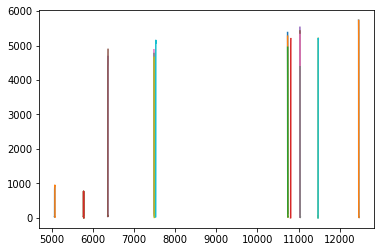

In [318]:
for i in temp:
    plt.plot(train.ix[i-3:i+3, 'BFPT_B_LP_SPEED_INPUT__1__'])
    print (train.ix[i-3:i+3, 'BFPT_B_LP_SPEED_INPUT__1__'])

# Change Point based on RPM<>200 Transition

In [340]:
cp_inc = train.index[(train['BFPT_B_LP_SPEED_INPUT__1__'] > 200) & (train['BFPT_B_LP_SPEED_INPUT__1__'].shift(1) < 200)]
print(cp_inc)

Int64Index([5065, 5769, 6360, 7525, 10811, 11476], dtype='int64')


In [341]:
cp_dec = train.index[(train['BFPT_B_LP_SPEED_INPUT__1__'] > 200) & (train['BFPT_B_LP_SPEED_INPUT__1__'].shift(-1) < 200)]
print(cp_dec)

Int64Index([5071, 5769, 7486, 10739, 11039, 12467], dtype='int64')


Since index 5769 is common to both (meaning both 5768 and 5770 are less than 200), we will exclude that and merge the 2 changpoint index series. 

In [349]:
idx = pd.concat([pd.Series(cp_inc), pd.Series(cp_dec)]).drop_duplicates(keep=False).sort_values().values
print(idx)

[ 5065  5071  6360  7486  7525 10739 10811 11039 11476 12467]


In [380]:
for i in idx:
    print(train.ix[i-1:i+1, 'BFPT_B_LP_SPEED_INPUT__1__'])

5064     31.23
5065    816.18
5066    855.52
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
5070    778.31
5071    273.19
5072     22.53
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
6359      39.62
6360    2158.47
6361    4393.84
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
7485    1162.62
7486     263.66
7487     123.82
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
7524      28.19
7525    1674.33
7526    4602.39
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
10738    1369.95
10739     364.27
10740     134.85
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
10810       0.12
10811    2856.91
10812    4983.46
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
11038    1398.14
11039     353.22
11040      19.44
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
11475       0.00
11476     209.28
11477    1318.20
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64
12466    660.90
12467    259.34
12468     15.43
Name: BFPT_B_LP_SPEED_INPUT__1__, dtype: float64


In [348]:
idx[1]

KeyError: 1

In [471]:
j=0
df = {}
for i in np.arange(0, len(idx)/2):
    df[j/2] = train.ix[idx[j]:idx[j+1]]
    j = j+2

So df contains all the Pump Running data as distinct time series for each run.

In [487]:
import itertools
for sub in itertools.combinations(df.keys(), 1):
    print (sub)

(0.0,)
(1.0,)
(2.0,)
(3.0,)
(4.0,)


# Clustering RPM data for Detecting Operating States

Clustering is performed considering only RPM and not all the parameters since that was the criteria mentioned in the problem statement.

In [189]:
# k means clustering and their within sum of squares

wcss = []

#distortions = []

for k in range(1,15):
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(np.array(train['BFPT_B_LP_SPEED_INPUT__1__']).reshape(-1,1))
    
    wcss.append(kmeans.inertia_)
    
    #distortions.append(sum(np.min(cdist(passoff, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / passoff.shape[0])

print(wcss)
#print(distortions)


[93646271217.38126, 186973518.9000396, 81018423.76860043, 56406069.555392556, 36340990.19871841, 24503451.22803618, 18806909.614660148, 14872415.557430308, 12220010.818930492, 9511061.568736289, 8169089.07318167, 6955676.375354752, 6157199.160749067, 5221453.075266866]


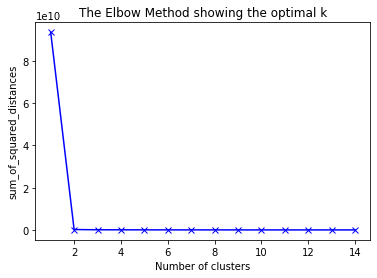

In [190]:
# Plot the elbow
plt.plot(range(1,15), wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('sum_of_squared_distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [214]:
##Fitting kmeans to the dataset with k=2
kmeans=KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(np.array(train['BFPT_B_LP_SPEED_INPUT__1__']).reshape(-1,1))

In [371]:
print ("The upper and lower bounds of Cluster 0 are: ")
train.loc[(y_kmeans == 0), 'BFPT_B_LP_SPEED_INPUT__1__'].min(), train.loc[(y_kmeans == 0), 'BFPT_B_LP_SPEED_INPUT__1__'].max()

The upper and lower bounds of Cluster 0 are: 


(0.0, 2158.47)

In [405]:
print ("The upper and lower bounds of Cluster 1 are: ")
train.loc[(y_kmeans == 1), 'BFPT_B_LP_SPEED_INPUT__1__'].min(), train.loc[(y_kmeans == 1), 'BFPT_B_LP_SPEED_INPUT__1__'].max()

The upper and lower bounds of Cluster 1 are: 


(2856.91, 5847.5)

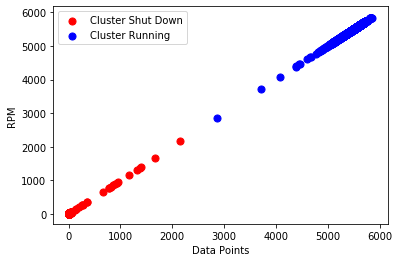

In [406]:
y_kmeans.shape
np.unique(y_kmeans)
#Visualising the clusters
plt.scatter(train.loc[(y_kmeans == 0), 'BFPT_B_LP_SPEED_INPUT__1__'], train.loc[(y_kmeans == 0), 'BFPT_B_LP_SPEED_INPUT__1__'], s = 50, c = 'red', label = 'Cluster Shut Down')
plt.scatter(train.loc[(y_kmeans == 1), 'BFPT_B_LP_SPEED_INPUT__1__'], train.loc[(y_kmeans == 1), 'BFPT_B_LP_SPEED_INPUT__1__'], s = 50, c = 'blue', label = 'Cluster Running')
plt.xlabel('Data Points')
plt.ylabel('RPM')
plt.legend()
plt.show()

Pump Running data from Cluster 1

In [424]:
train_clust = train.loc[(y_kmeans == 1),:]

# Missing Value Imputation

In [425]:
print(draw_missing_data_table(train_clust).sort_values(by = 'Percent', ascending=False))

                            Total   Percent
BFP_2B_IBRD_SEAL_INJ_FLOW_   5540  0.998018
BFP_2B_OBRD_SEAL_INJ_FLOW_   1307  0.235453
BFP_SUCT_HDR_PRESS________    308  0.055485
BFPT_2B_RAD_SHAFT_VIB_IB_B      2  0.000360
2B_BFPT_ROTOR_VIB_OBRG____      1  0.000180
BFPT_2B_FIRST_STAGE_PRESS_      1  0.000180
BFP_2B_LUBE_OIL_PRESS_____      1  0.000180
BFPT_2B_RAD_SHAFT_VIB_OB_B      1  0.000180
BFP_2B_IBRD_SEAL_INJ_DRN_T      0  0.000000
BFPT_2B_AXIAL_SHAFT_VIB___      0  0.000000
BFP_2B_RAD_SHAFT_VIB_IB_BR      0  0.000000
BFP_2B_RAD_SHAFT_VIB_OB_BR      0  0.000000
BFPT_2B_THRUST_BRG_WEAR___      0  0.000000
BFP_2B_AXIAL_SHAFT_VIB____      0  0.000000
2B_BFPT_ROTOR_VIB_IBRB____      0  0.000000
BFP_2B_OBRD_SEAL_INJ_DRN_T      0  0.000000
BFP_2B_BARREL_BOT_IBRD_TEM      0  0.000000
BFPT_2B_IN_BRG_MTL_TEMP___      0  0.000000
BFP_2B_BARREL_BOT_OBRD_TEM      0  0.000000
BFP_2B_BARREL_TOP_OBRD_TEM      0  0.000000
EXT_STM_FLOW_TO_BFP_2B____      0  0.000000
BFP_2B_BARREL_TOP_IBRD_TEM      

In [467]:
#Removing variables with more than 40% missing values
train_clust.drop(['BFP_2B_IBRD_SEAL_INJ_FLOW_'], axis = 1, inplace = True)
for i in df:
    df.get(i).drop(['BFP_2B_IBRD_SEAL_INJ_FLOW_'], axis = 1, inplace = True)

In [427]:
#Imputing Missing Values
train_clust = train_clust.interpolate(method = 'linear')
#We will use backfill to fill remaining null values. 
train_clust = train_clust.fillna(method = 'bfill')

# Checking for Negative Values (Sanity check)

In [428]:
# Finding no of values in every column which are negative
train_clust.drop('DATETIME', axis=1).apply(lambda x: sum(x < 0),axis=0)

BFP_SEAL_WATER_FLOW              0
BFP_SUCT_HDR_PRESS________       0
AUX_CDSR_2B_PRESS_________       0
BFP_SUCTION_HDR_TEMP______       0
BFPT_B_VALVE_DEMAND_HP_STO       0
BFPT_B_VALVE_DEMAND_LP_STO       0
BFPT_B_CALC_VALVE_DEMAND__       0
2B_TDBFP_RECIRC_VLV_DMD___       0
BFP_2B_DISCHARGE_FLOW_____       0
BFP_2B_OBRD_SEAL_INJ_FLOW_       0
2B_TDBFP_DISCHARGE_FLOW___       3
BFP_2B_BAL_DRUM_FLOW______       0
2B_TDBFP_RECIRC_VLV_POS___    5454
BFP_DSCH_HDR_PRESS________       0
BFP_2B_LUBE_OIL_PRESS_____       0
BFPT_2B_FIRST_STAGE_PRESS_       0
2B_TDBFP_RECIRC_FLOW______       0
BFPT_B_LP_SPEED_INPUT__1__       0
BFPT_B_LP_SPEED_INPUT__2__       0
BFP_DISCHARGE_HEADER_TEMP_       0
BFP_2B_THRUST_BRG_TEMP____       0
BFP_2B_IN_BRG_TEMP________       0
BFP_2B_OUT_BRG_TEMP_______       0
BFPT_2B_BRG_1_DRAIN_TEMP__       0
BFPT_2B_BRG_2_DRAIN_TEMP__       0
BFPT_2B_THRUST_BRG_DRAIN__       0
BFP_2B_BARREL_TOP_IBRD_TEM       0
BFP_2B_BARREL_BOT_IBRD_TEM       0
BFP_2B_BARREL_TOP_OB

Valve position (VLV_POS) may be negative, so we leave it as it is.  BRG_WEAR I am guessing stands for Bearing Wear. It may also be negative. 

Preprocessing steps for Change Point Dict

In [473]:
for i in df:
    # Removing BFP_2B_IBRD_SEAL_INJ_FLOW_ & DATETIME Variables
    df[i].drop(['DATETIME', 'BFP_2B_IBRD_SEAL_INJ_FLOW_'], axis = 1, inplace = True)
    # Missing Value Imputation
    df[i] = df[i].interpolate(method = 'linear')
    #We will use backfill to fill remaining null values. 
    df[i] = df[i].fillna(method = 'bfill')

# Low Variance Filter

In [474]:
# Checking variables which have very low variance (less than 0.1)

selector = VarianceThreshold()
selector.fit_transform(train_clust.drop('DATETIME', axis=1))
temp = train_clust.drop('DATETIME', axis=1).loc[:, selector.get_support()]
temp.shape, train_clust.shape

((5551, 46), (5551, 47))

No variables have such low variance.

# Drop Variables with Very High Correlation

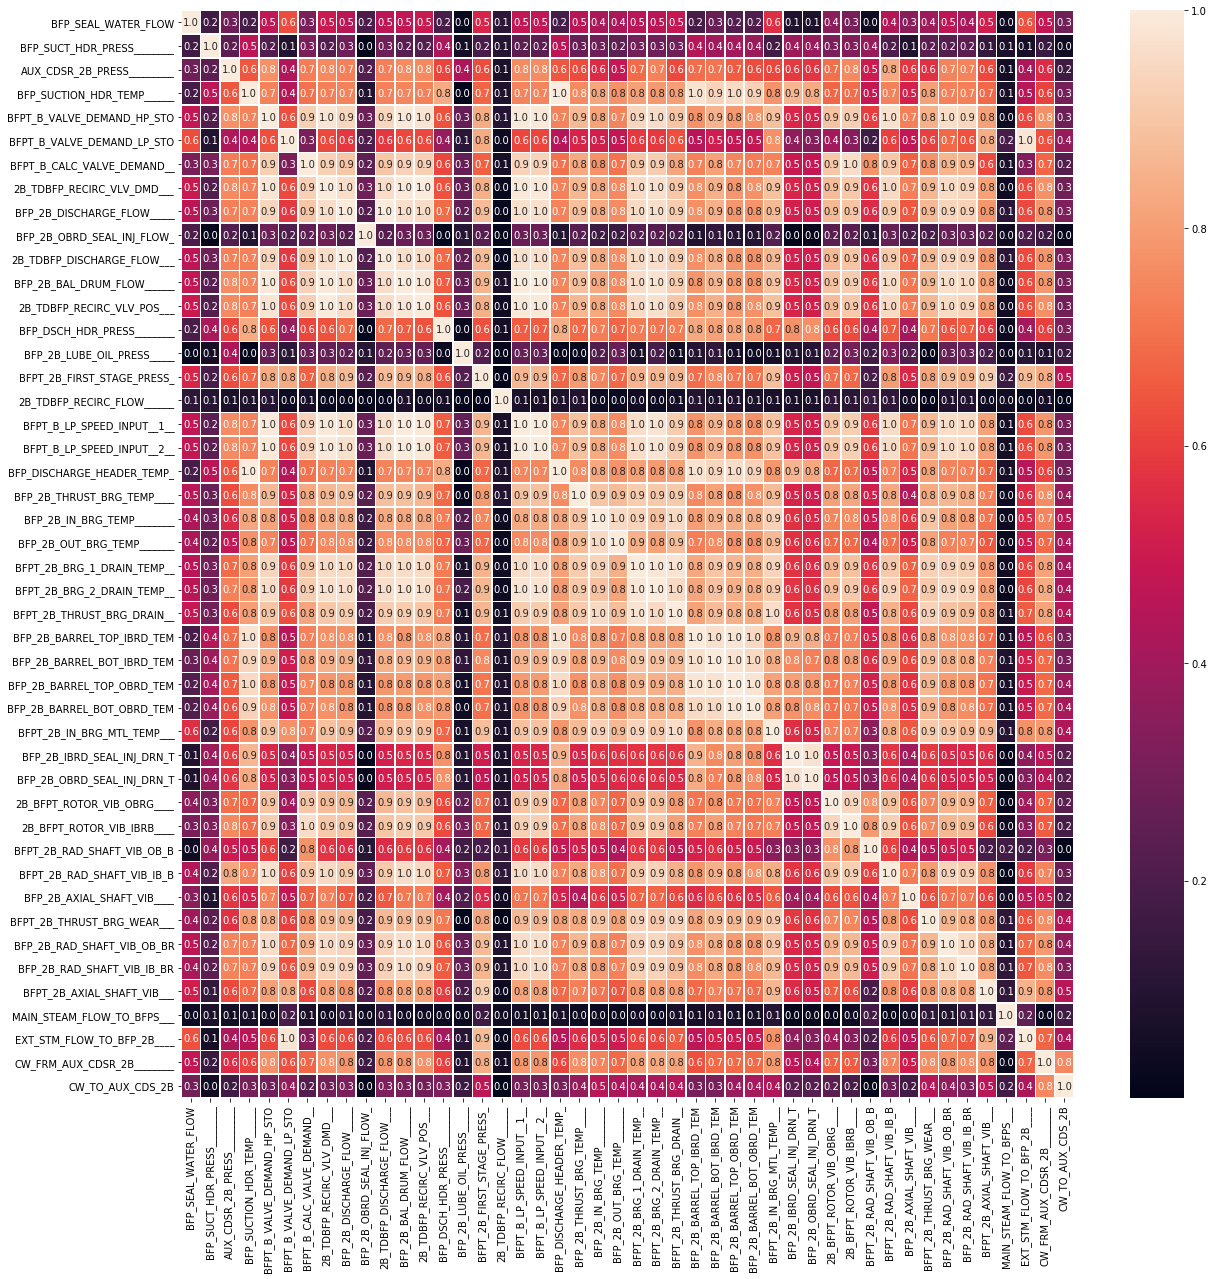

In [389]:
# Create correlation matrix
corr_matrix = train_clust.drop('DATETIME', axis=1).corr(method='pearson').abs()
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [430]:
# Check and drop coulmns which have more than 0.95 correlation with other columns
columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train_clust.drop('DATETIME', axis=1).columns[columns]

In [431]:
selected_columns.shape

(19,)

So remaining columns are dropped in this subset. 

In [491]:
train_clustsub = train_clust[selected_columns]
train_clustsub.shape

(5551, 19)

# Splitting into Train and Validation Sets

In [492]:
train_clustsub.head()

,BFP_SEAL_WATER_FLOW,BFP_SUCT_HDR_PRESS________,AUX_CDSR_2B_PRESS_________,BFP_SUCTION_HDR_TEMP______,BFPT_B_VALVE_DEMAND_HP_STO,BFPT_B_VALVE_DEMAND_LP_STO,BFP_2B_OBRD_SEAL_INJ_FLOW_,BFP_DSCH_HDR_PRESS________,BFP_2B_LUBE_OIL_PRESS_____,BFPT_2B_FIRST_STAGE_PRESS_,2B_TDBFP_RECIRC_FLOW______,BFP_2B_THRUST_BRG_TEMP____,BFP_2B_IN_BRG_TEMP________,BFP_2B_IBRD_SEAL_INJ_DRN_T,BFPT_2B_RAD_SHAFT_VIB_OB_B,BFP_2B_AXIAL_SHAFT_VIB____,MAIN_STEAM_FLOW_TO_BFPS___,CW_FRM_AUX_CDSR_2B________,CW_TO_AUX_CDS_2B
6361,38.51,86.99,5.39,277.09,30.01,30.01,6.45,2217.85,26.47,20.95,247.95,144.30,99.69,150.87,1.10,1.58,7.51,105.83,82.39
6362,38.32,86.54,5.62,277.79,30.01,30.01,6.45,2274.01,26.08,21.45,252.66,146.64,104.04,168.64,1.34,1.59,7.51,107.90,82.39
6363,38.12,86.09,5.72,278.49,30.01,30.01,6.45,2330.16,25.69,24.10,256.48,148.98,108.39,167.18,1.58,1.61,7.51,109.97,82.38
6364,37.93,86.32,5.81,279.19,30.01,30.01,6.45,2361.96,25.62,29.76,253.78,130.01,111.10,165.71,1.68,1.62,7.51,111.13,82.38
6365,37.74,87.17,5.91,279.89,30.01,30.01,6.45,2365.65,25.56,28.61,8.04,130.74,112.62,166.82,1.55,1.64,7.51,111.37,82.38


#### Standardization of data 

In [493]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#scalar = StandardScaler()
scalar = MinMaxScaler()

train_clustsub = train_clustsub.as_matrix()
train_clustsub = scalar.fit_transform(train_clustsub)


# Scaling the time series data in the Change Point Dict as well
for i in df:
    df[i] = df[i].as_matrix()
    df[i] = scalar.fit_transform(df[i])
    

In [494]:
train_clustsub.shape

(5551, 19)

# Autoencoder Model

We will fit a simple Autoencoder model for demonstration purposes. 

In [498]:
input_dim = train_clustsub.shape[1]
encoding_dim = 5

input_layer = Input(shape=(input_dim, ))

encoder = Dense(32, activation="relu", activity_regularizer=regularizers.l1(10e-5),kernel_constraint=UnitNorm(axis=0))(input_layer)
encoder = Dense(16, activation="relu")(encoder)


decoder = Dense(8, activation='relu',kernel_constraint=UnitNorm(axis=1))(encoder)
decoder = Dense(16, activation='relu')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


nb_epoch = 100
batch_size = 64

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)


In [499]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 19)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                640       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_20 (Dense)             (None, 19)                323       
Total params: 1,763
Trainable params: 1,763
Non-trainable params: 0
_________________________________________________________________


In [501]:
X_train, X_validation = train_test_split(train_clustsub, test_size=0.3, random_state=42, shuffle = True)
history = autoencoder.fit(X_train, X_train,
                                      epochs=nb_epoch,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      validation_data=(X_validation, X_validation),
                                      verbose=1,
                                      callbacks=[checkpointer, tensorboard]
                                     ).history

Train on 3885 samples, validate on 1666 samples
Epoch 1/100
3885/3885 [==============================] - 0s 36us/step - loss: 0.0142 - acc: 0.4625 - val_loss: 0.0103 - val_acc: 0.7647

Epoch 00001: val_loss improved from 0.07209 to 0.01034, saving model to model.h5
Epoch 2/100
3885/3885 [==============================] - 0s 57us/step - loss: 0.0085 - acc: 0.8605 - val_loss: 0.0073 - val_acc: 0.8974

Epoch 00002: val_loss improved from 0.01034 to 0.00729, saving model to model.h5
Epoch 3/100
3885/3885 [==============================] - 0s 29us/step - loss: 0.0068 - acc: 0.9035 - val_loss: 0.0066 - val_acc: 0.9070

Epoch 00003: val_loss improved from 0.00729 to 0.00658, saving model to model.h5
Epoch 4/100
3885/3885 [==============================] - 0s 38us/step - loss: 0.0063 - acc: 0.9091 - val_loss: 0.0063 - val_acc: 0.9112

Epoch 00004: val_loss improved from 0.00658 to 0.00627, saving model to model.h5
Epoch 5/100
3885/3885 [==============================] - 0s 27us/step - loss: 0.

Train on 4440 samples, validate on 1111 samples
Epoch 1/100
4440/4440 [==============================] - 1s 132us/step - loss: 0.2576 - acc: 0.0223 - val_loss: 0.1712 - val_acc: 0.4959

Epoch 00001: val_loss improved from inf to 0.17120, saving model to model.h5
Epoch 2/100
4440/4440 [==============================] - 0s 24us/step - loss: 0.1529 - acc: 0.5613 - val_loss: 0.0984 - val_acc: 0.9910

Epoch 00002: val_loss improved from 0.17120 to 0.09841, saving model to model.h5
Epoch 3/100
4440/4440 [==============================] - 0s 25us/step - loss: 0.1131 - acc: 0.7300 - val_loss: 0.0924 - val_acc: 0.9262

Epoch 00003: val_loss improved from 0.09841 to 0.09236, saving model to model.h5
Epoch 4/100
4440/4440 [==============================] - 0s 25us/step - loss: 0.1055 - acc: 0.7964 - val_loss: 0.0895 - val_acc: 0.9352

Epoch 00004: val_loss improved from 0.09236 to 0.08951, saving model to model.h5
Epoch 5/100
4440/4440 [==============================] - 0s 25us/step - loss: 0.101

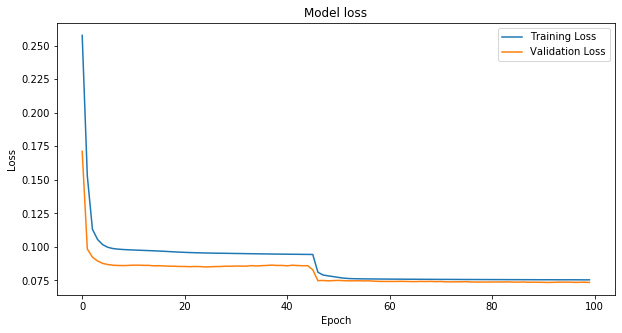

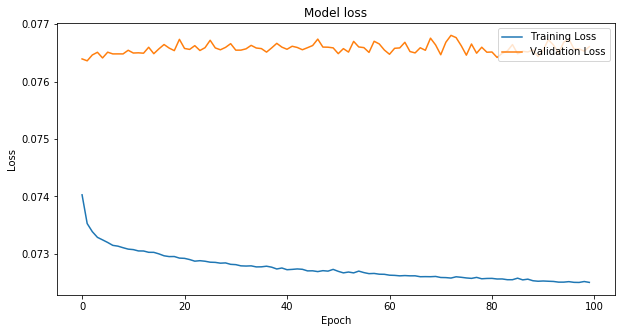

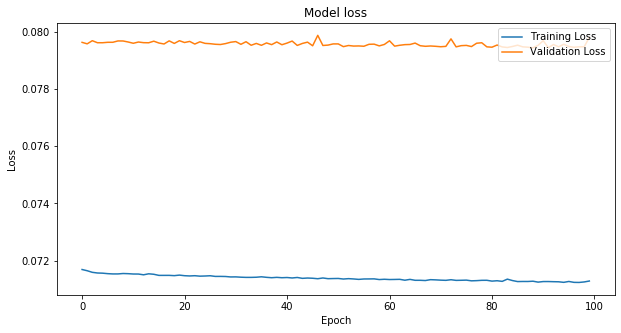

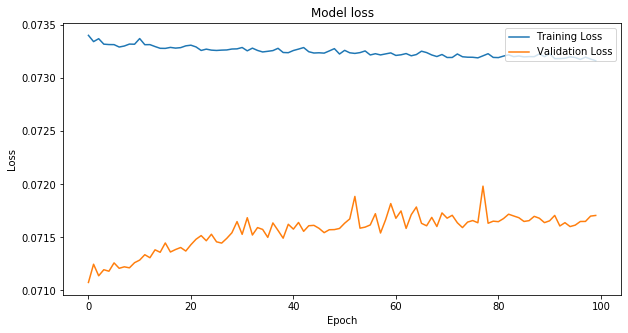

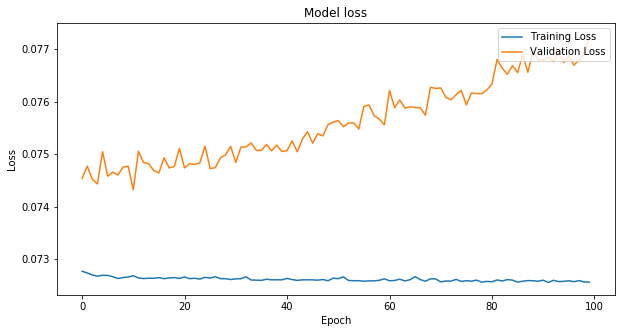

In [465]:
kf = KFold(n_splits=5)

kf.get_n_splits(train_clustsub)
for train_index, test_index in kf.split(train_clustsub):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_validation = train_clustsub[train_index], train_clustsub[test_index]

            history = autoencoder.fit(X_train, X_train,
                                      epochs=nb_epoch,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      validation_data=(X_validation, X_validation),
                                      verbose=1,
                                      callbacks=[checkpointer, tensorboard]
                                     ).history
            
            fig, ax = plt.subplots(figsize=(10,5))
            ax.plot(history['loss'])
            ax.plot(history['val_loss'])
            ax.set_title('Model loss')
            ax.set_ylabel('Loss')
            ax.set_xlabel('Epoch')
            ax.legend(['Training Loss', 'Validation Loss'], loc='upper right')
            plt.show()

# autoencoder = load_model('model.h5')

In [489]:
# import itertools
# for sub in itertools.combinations(df.keys(), 2):
#     print (sub)

kf = KFold(n_splits=5)

kf.get_n_splits(df)
for train_index, test_index in kf.split(df):
            print("TRAIN:", train_index, "TEST:", test_index)
#             X_train, X_validation = train_clustsub[train_index], train_clustsub[test_index]

#             history = autoencoder.fit(X_train, X_train,
#                                       epochs=nb_epoch,
#                                       batch_size=batch_size,
#                                       shuffle=True,
#                                       validation_data=(X_validation, X_validation),
#                                       verbose=1,
#                                       callbacks=[checkpointer, tensorboard]
#                                      ).history
            
#             fig, ax = plt.subplots(figsize=(10,5))
#             ax.plot(history['loss'])
#             ax.plot(history['val_loss'])
#             ax.set_title('Model loss')
#             ax.set_ylabel('Loss')
#             ax.set_xlabel('Epoch')
#             ax.legend(['Training Loss', 'Validation Loss'], loc='upper right')
#             plt.show()

# # autoencoder = load_model('model.h5')

TRAIN: [1 2 3 4] TEST: [0]
TRAIN: [0 2 3 4] TEST: [1]
TRAIN: [0 1 3 4] TEST: [2]
TRAIN: [0 1 2 4] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]


In [490]:
type(train_index)

numpy.ndarray

### Visualizing the Training and Validation Convergence

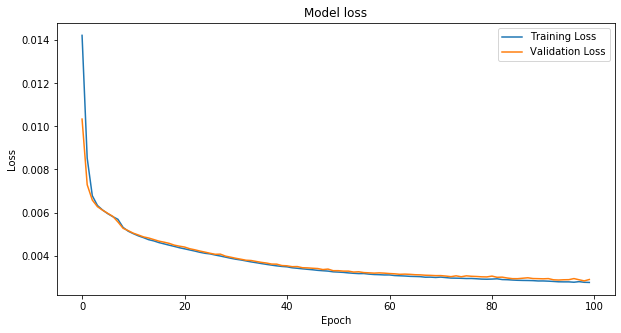

In [503]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(history['loss'])
ax.plot(history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


From the above graph we can see that both validation and training losses are converging nicely. So the model is neither 
overfitting nor underfitting.

Reconstruction Error for Training Set

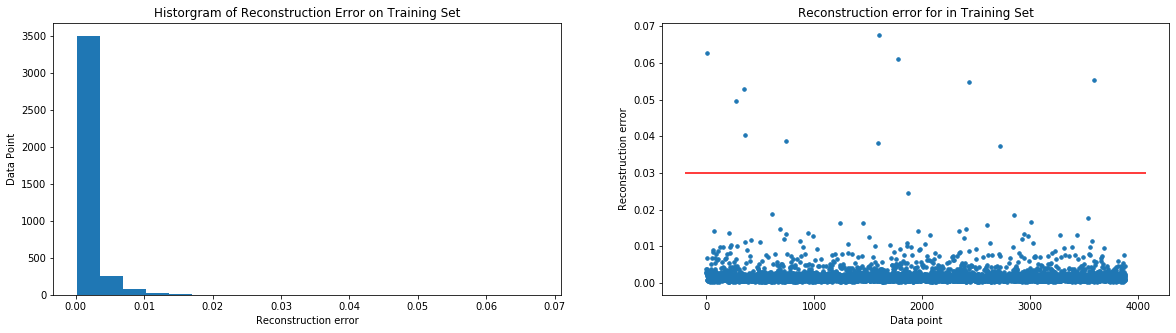

In [508]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
fig, ax = plt.subplots(1,2,figsize=(20,5))
_ = ax[0].hist(mse, bins=20)
_ = ax[0].set_title('Historgram of Reconstruction Error on Training Set')
_ = ax[0].set_xlabel("Reconstruction error")
_ = ax[0].set_ylabel("Data Point")
_ = ax[1].plot(np.arange(mse.size), mse, marker='o', ms=3.5, linestyle='')
_ = ax[1].set_title('Reconstruction error for in Training Set')
_ = ax[1].set_ylabel("Reconstruction error")
_ = ax[1].set_xlabel("Data point")
threshold = 0.03
_ = ax[1].hlines(threshold, ax[1].get_xlim()[0], ax[1].get_xlim()[1], colors="r", zorder=100, label='Threshold')

In [509]:
print("Mean MSE is: ", np.mean(mse))
print("No of values above threshold is: ", len(mse[mse > threshold]))
print (" % of values above threshold is: ", len(mse[mse > threshold]) / mse.size * 100)

Mean MSE is:  0.0019733190844091345
No of values above threshold is:  11
 % of values above threshold is:  0.2831402831402831


Predictions & Reconstruction Error for Validation Set

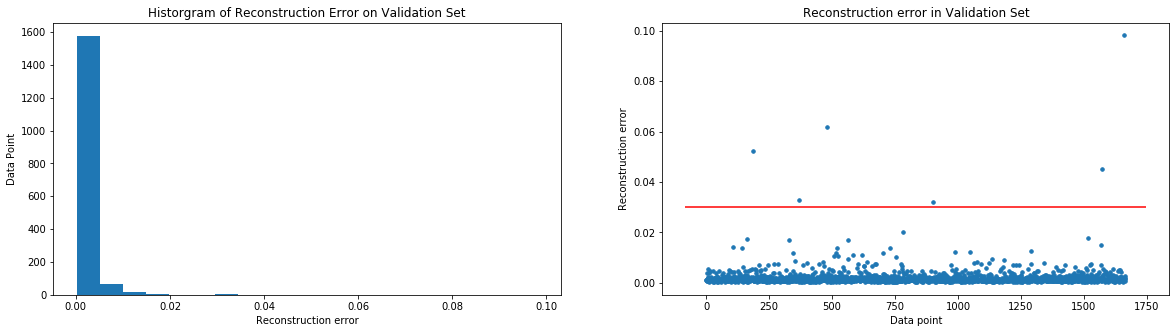

In [510]:
predictions = autoencoder.predict(X_validation)
mse = np.mean(np.power(X_validation - predictions, 2), axis=1)
fig, ax = plt.subplots(1,2,figsize=(20,5))
_ = ax[0].hist(mse, bins=20)
_ = ax[0].set_title('Historgram of Reconstruction Error on Validation Set')
_ = ax[0].set_xlabel("Reconstruction error")
_ = ax[0].set_ylabel("Data Point")
_ = ax[1].plot(np.arange(mse.size), mse, marker='o', ms=3.5, linestyle='')
_ = ax[1].set_title('Reconstruction error in Validation Set')
_ = ax[1].set_ylabel("Reconstruction error")
_ = ax[1].set_xlabel("Data point")
threshold = 0.03
_ = ax[1].hlines(threshold, ax[1].get_xlim()[0], ax[1].get_xlim()[1], colors="r", zorder=100, label='Threshold')

In [511]:
print("Mean MSE is: ", np.mean(mse))
print("No of values above threshold is: ", len(mse[mse > threshold]))
print (" % of values above threshold is: ", len(mse[mse > threshold]) / mse.size * 100)

Mean MSE is:  0.002076436419635143
No of values above threshold is:  6
 % of values above threshold is:  0.36014405762304924


Setting a threshold of 0.03 for the reconstruction error, we find 11 anomalous points in the training set and 6 anomalous points in the validation set. 